**Table of contents**<a id='toc0_'></a>    
- [Problem 1: MNL demand](#toc1_)    
  - [1(a) Run OLS for MNL](#toc1_1_)    
  - [1(a)-2: Run another OLS, adding j-specific time-invariant constants as j-firm specific shocks. No significant change in estimations.](#toc1_2_)    
  - [1(b): Now use IV for price. Simplity using ingredients prices. ](#toc1_3_)    
  - [1(c): Calculate own price derivative and own price elasticity](#toc1_4_)    
  - [1(d): Calculate cross price derivatives and elasiticity with product 1](#toc1_5_)    
  - [1(e):generate Jacobian](#toc1_6_)    
  - [Compare estimations from different methods](#toc1_7_)    
- [Problem 2: Nested Logit Demand](#toc2_)    
  - [2(a) (OLS)IV for Nested logit demand estimation](#toc2_1_)    
  - [2(b): calculate price elasiticy and derivatives under Nested Logit Setting](#toc2_2_)    
  - [2(c): Just call function for cross price elasiticities and derivatives with 1](#toc2_3_)    
  - [2(d)](#toc2_4_)    
  - [2(e):Just call last jacobbian and print](#toc2_5_)    
- [3: use nested logit demand and FOC..](#toc3_)    
  - [3(a): Estimating constant costs](#toc3_1_)    
  - [3(a)-1: check fully competition context](#toc3_2_)    
  - [3(b): a merge between 1 and 2](#toc3_3_)    
  - [3(d): when all firms are colluding](#toc3_4_)    
    - [3(d)-1: Direct maximize profit](#toc3_4_1_)    
  - [3(e). Analysis](#toc3_5_)    
  - [3(a)-1,3(b),3(d).Comparison results: Intuition?](#toc3_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from functions_homework1 import *

import warnings
warnings.filterwarnings("ignore")

global demand_df, c_jt_dic, PARAMS, alpha, Temp_t, data, params_IV, nest_params_IV
global p_jt_dic, s_jt_dic, s_jmidgt_dic, s_gt_dic

# <a id='toc1_'></a>[Problem 1: MNL demand](#toc0_)
## <a id='toc1_1_'></a>[1(a) Run OLS for MNL](#toc0_)
In this part I reg $ln(s_{jt}/s_{0t})$ to $X_{jt},p_{jt}$, no constant. This means I treat $\xi_j$ as noise in regression with mean 0. In 1(b) I take them as constants.


In [2]:
Dic_para_q1 = dict()
Dic_para_q2q3 = dict()
# Load the data
data = pd.read_csv('product_data.csv')
data = prepare_data(data)

# Prepare the design matrix X and dependent variable y
# X = data[['price', 'sugar', 'caffeine', 'Diet', 'Regular']]
# y = data['log_odds']

# # Fit the model
# model = sm.OLS(y, X)
# model_results = model.fit()

model_results = run_2sls(data,['log_odds'],['price', 'sugar', 'caffeine', 'Diet', 'Regular'],[],[])

# Print the results
print(model_results.summary())

params_ols = get_parameters(model_results, nested=False, print_results=False)
Dic_para_q1['OLS'] = params_ols

                          IV2SLS Regression Results                           
Dep. Variable:               log_odds   R-squared:                       0.885
Model:                         IV2SLS   Adj. R-squared:                  0.884
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Sat, 21 Sep 2024                                         
Time:                        22:49:48                                         
No. Observations:                1000                                         
Df Residuals:                     995                                         
Df Model:                           4                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price         -1.6261      0.021    -77.352      0.0

## <a id='toc1_2_'></a>[1(a)-2: Run another OLS, adding j-specific time-invariant constants as j-firm specific shocks. No significant change in estimations.](#toc0_)
In this part I reg $ln(s_{jt}/s_{0t})$ to $X_{jt},p_{jt}$, no constant and 9 dummies for each j (drop ID_1). This means I treat $\xi_j$ as fixed within periods in regression.

In [3]:
# ID_dummies = pd.get_dummies(data['product_ID'], prefix='ID').astype(int)
# ID_dummies = ID_dummies.drop('ID_1', axis=1)

# X = pd.concat([X, ID_dummies], axis=1)
# y = data['log_odds']

# # Fit the model
# model = sm.OLS(y, X)
# model_results = model.fit()

# # Print the results
# params_ols_fixed_effect = get_parameters(
#     model_results, nested=False, print_results=True)
# Dic_para_q1['OLS_fixed_effect'] = params_ols_fixed_effect

## <a id='toc1_3_'></a>[1(b): Now use IV for price. Simplity using ingredients prices. ](#toc0_)
The main concern of endogeneity is that $P_j$ is affected by $\xi_j$, say brand effect.

So use price for ingredients: sugar and caffine price.

They are valid IV, since firm j's ingredients' price certainly affect price via cost, but they have little relationship with firm j's brand effect. (using other firms' ingredients price are not valid since they are not related with firm j's price)

In [4]:
iv_results = run_2sls(data,['log_odds'],['price', 'sugar', 'caffeine', 'Diet', 'Regular'],['caffeine_extract_price','corn_syrup_price'],['price'])

# Print the results
params_IV = get_parameters(iv_results, nested=False, print_results=True)
Dic_para_q1['IV'] = params_IV

alpha (price): -1.4104
beta1 (sugar): 1.4277
beta2 (caffeine): 1.3821
gamma_D (Diet): -2.5573
gamma_R (Regular): -6.6182


## <a id='toc1_4_'></a>[1(c): Calculate own price derivative and own price elasticity](#toc0_)
Let $M=\sum_{k\neq j} exp(\delta_k)+1$, then $\frac{\partial s_{jt}}{\partial p_{jt}}=\frac{Mexp(\delta_{jt})}{(M+exp(\delta_{jt}))^2}\alpha=\alpha s_{jt}(1-s_{jt})$

In [5]:
# Function to calculate own-price derivative
def own_price_derivative(alpha, s_jt):
    return alpha * s_jt * (1 - s_jt)

# Function to calculate own-price elasticity
def own_price_elasticity(alpha, p_jt, s_jt):
    return alpha * p_jt * (1 - s_jt)

# Given df and params, calculate the own-price derivative and elasticity, Under any MNL setting
# return mean elasticity for Regular and Diet drinks, and modified df
def own_PD_PE(df, params):
    """take alpha and call the function, return the results"""
    data = df.copy()
    # Calculate own-price derivatives and elasticities
    alpha = params['alpha']
    data['own_price_derivative'] = own_price_derivative(
        alpha, data['market_share'])
    data['own_price_elasticity'] = own_price_elasticity(
        alpha, data['price'], data['market_share'])

    # Calculate mean elasticities for Regular and Diet drinks
    mean_elasticity_regular = data[data['nest']
                                   == 'Regular']['own_price_elasticity'].mean()
    mean_elasticity_diet = data[data['nest'] ==
                                'Diet']['own_price_elasticity'].mean()

    print(
        f"Mean own-price elasticity for Regular drinks: {mean_elasticity_regular:.4f}")
    print(
        f"Mean own-price elasticity for Diet drinks: {mean_elasticity_diet:.4f}")

    return [mean_elasticity_regular, mean_elasticity_diet, data]


[mean_elasticity_regular, mean_elasticity_diet,
    data] = own_PD_PE(data, params_IV)
Dic_para_q2q3['own_elasticity_regular_1c'] = mean_elasticity_regular
Dic_para_q2q3['own_elasticity_diet_1c'] = mean_elasticity_diet

Mean own-price elasticity for Regular drinks: -4.2011
Mean own-price elasticity for Diet drinks: -2.9747


## <a id='toc1_5_'></a>[1(d): Calculate cross price derivatives and elasiticity with product 1](#toc0_)
Similarly $\frac{\partial s_{jt}}{\partial p_{1t}}=-\alpha s_{jt}s_{1t}$
Compared to 1(c), cross price derivatives are positive, (own should be certainly negative). Also I expect under MNL setting, cross price elasiticity within group is larger. However here I get wrong directions

In [6]:
# Function to calculate cross-price derivative
def cross_price_derivative(alpha, s_jt, s_it):
    return -alpha * s_jt * s_it

# Function to calculate cross-price elasticity
def cross_price_elasticity(alpha, p_1t, s_jt, s_1t):
    return -alpha * p_1t * s_jt

# Given df and params, calculate the cross-price derivative and elasticity with product 1, Under any MNL setting. return mean elasticity for Regular and Diet drinks, and modified df
def cross_PD_PE(df, params):
    data = df.copy()
    alpha = params['alpha']

    # Get product 1's market share for each time period
    product_1_share = data[data['product_ID'] == 1].set_index('t')[
        'market_share']

    # Calculate cross-price derivatives and elasticities
    data['cross_price_derivative'] = data.apply(lambda row: cross_price_derivative(alpha, row['market_share'], product_1_share[row['t']])
                                                if row['product_ID'] != 1 else np.nan, axis=1)

    data['cross_price_elasticity'] = data.apply(lambda row: cross_price_elasticity(alpha, data.loc[(data['product_ID'] == 1) & (data['t'] == row['t']), 'price'].values[0],
                                                row['market_share'], product_1_share[row['t']])
                                                if row['product_ID'] != 1 else np.nan, axis=1)

    # Calculate mean cross-price elasticities
    mean_cross_elasticity_diet = data[(data['nest'] == 'Diet') & (
        data['product_ID'] != 1)]['cross_price_elasticity'].mean()
    mean_cross_elasticity_regular = data[(data['nest'] == 'Regular') & (
        data['product_ID'] != 1)]['cross_price_elasticity'].mean()

    print(
        f"Mean cross-price elasticity between product 1 and Diet sodas: {mean_cross_elasticity_diet:.4f}")
    print(
        f"Mean cross-price elasticity between product 1 and Regular sodas: {mean_cross_elasticity_regular:.4f}")
    return [mean_cross_elasticity_diet, mean_cross_elasticity_regular, data]


[mean_cross_elasticity_diet, mean_cross_elasticity_regular,
    data] = cross_PD_PE(data, params_IV)
Dic_para_q2q3['cross_elasticity_regular_1d'] = mean_cross_elasticity_regular
Dic_para_q2q3['cross_elasticity_diet_1d'] = mean_cross_elasticity_diet

Mean cross-price elasticity between product 1 and Diet sodas: 0.2054
Mean cross-price elasticity between product 1 and Regular sodas: 0.3867


## <a id='toc1_6_'></a>[1(e):generate Jacobian](#toc0_)
Use the formula that $\frac{\partial s_{jt}}{\partial p_{it}}=-\alpha s_{jt}s_{it}$

In [7]:
def generate_jacobian(time_period, data, params):
    """
    Generate the Jacobian matrix of price derivatives for a given time period.
    I Do need market_share column in the data pd
    Returns: np.array like Jacobian matrix of price derivatives.
    """
    alpha = params['alpha']
    # Filter data for the given time period
    period_data = data[data['t'] == time_period]
    n_products = len(period_data)
    shares = period_data['market_share'].values

    # Initialize the Jacobian matrix
    jacobian = np.zeros((n_products, n_products))

    # Fill in the Jacobian matrix
    for i in range(n_products):
        for j in range(n_products):
            if i == j:
                # Own-price derivative
                s_it = shares[i]
                jacobian[i, i] = own_price_derivative(alpha, s_it)
            else:
                # Cross-price derivative
                s_jt = shares[j]
                s_it = shares[i]
                jacobian[i, j] = cross_price_derivative(alpha, s_jt,  s_it)

    return jacobian


def print_jacobian(data, params_IV):
    # Generate Jacobian for the last time period
    last_period = data['t'].max()
    jacobian_last_period = generate_jacobian(last_period, data, params_IV)
    print(f"Jacobian matrix for period {last_period}:")
    print(np.round(jacobian_last_period, 3))


data_Q1 = data.copy()
print_jacobian(data, params_IV)

Jacobian matrix for period 100:
[[-0.083  0.     0.001  0.002  0.022  0.003  0.039  0.009  0.004  0.003]
 [ 0.    -0.002  0.     0.     0.     0.     0.001  0.     0.     0.   ]
 [ 0.001  0.    -0.014  0.     0.004  0.001  0.006  0.001  0.001  0.001]
 [ 0.002  0.     0.    -0.028  0.007  0.001  0.013  0.003  0.001  0.001]
 [ 0.022  0.     0.004  0.007 -0.261  0.014  0.154  0.033  0.014  0.012]
 [ 0.003  0.     0.001  0.001  0.014 -0.053  0.025  0.005  0.002  0.002]
 [ 0.039  0.001  0.006  0.013  0.154  0.025 -0.348  0.06   0.026  0.023]
 [ 0.009  0.     0.001  0.003  0.033  0.005  0.06  -0.123  0.006  0.005]
 [ 0.004  0.     0.001  0.001  0.014  0.002  0.026  0.006 -0.055  0.002]
 [ 0.003  0.     0.001  0.001  0.012  0.002  0.023  0.005  0.002 -0.049]]


## <a id='toc1_7_'></a>[Compare estimations from different methods](#toc0_)

In [8]:
pd.DataFrame(Dic_para_q1)

,OLS,IV
alpha,-1.626102,-1.410449
beta1,1.528062,1.427685
beta2,1.445800,1.382064
gamma_D,-2.440599,-2.557333
gamma_R,-6.692118,-6.618158


# <a id='toc2_'></a>[Problem 2: Nested Logit Demand](#toc0_)

## <a id='toc2_1_'></a>[2(a) (OLS)IV for Nested logit demand estimation](#toc0_)
If we use OLS I need to estimate 
$$log(odd share_{jt}) = \alpha* price_{jt}+\beta_1* sugar_{jt}+\beta_2 *caffine_{jt}+\gamma_D*Diet_{jt}+\gamma_R*Regular_{jt}+\sigma log(s_{jt \mid g})+\xi_{jt}$$

Now If I'm considering IV, clearly both price and log_within_share is endogenous since they are both affected by brand effects.

- For price, I can still use ingredients price as IV, like before.

- For log_within_share, I create new IV $caffine_{-j,t\mid g},sugar_{-j,t\mid g}$:

    - other firms' (within group) sugar and caffine level affects their competition, so affects firm j's within group share

    - other firms' sugar and caffine level has nothing to do with firm j's brand effects.

In [9]:
Dic_para_q2 = dict()

In [10]:
# Create log_within_share
data['group_share'] = data.groupby(
    ['t', 'nest'])['market_share'].transform('sum')
data['within_group_share'] = data['market_share'] / data['group_share']
data['log_within_share'] = np.log(data['within_group_share'])

# Create sugar_mean_within_group: other products' average sugar content within the same nest
# So I generate sum of sugar content for each nest, and then subtract the sugar content of the product itself
# then divide by the number of other products in the nest
data['others_sugar_mean_within_group'] = data.groupby( ['t', 'nest'])['sugar'].transform('sum') - data['sugar']
data['others_sugar_mean_within_group'] = data['others_sugar_mean_within_group'] / 4

# Create caffeine_mean_within_group: other products' average caffeine content within the same nest
data['others_caffeine_mean_within_group'] = data.groupby( ['t', 'nest'])['caffeine'].transform('sum') - data['caffeine']
data['others_caffeine_mean_within_group'] = data['others_caffeine_mean_within_group'] / 4

# Prepare the exogenous, endogenous, and instrumental variables: form lists
exog_list = ['sugar', 'caffeine', 'Diet', 'Regular']
endog_list = ['price','log_within_share']
IV_list = ['caffeine_extract_price','corn_syrup_price', 'others_sugar_mean_within_group', 'others_caffeine_mean_within_group']

# Perfpoem OLS estimation
ols_model_results = run_2sls(data,['log_odds'],exog_list+endog_list,[],[])
nest_params_ols = get_parameters(
    ols_model_results, nested=True, print_results=False)
Dic_para_q2['nest_OLS'] = nest_params_ols

# Perform 2SLS estimation
iv_model_results = run_2sls(data,['log_odds'],exog_list+endog_list,IV_list,endog_list)
nest_params_IV = get_parameters(
    iv_model_results, nested=True, print_results=False)
Dic_para_q2['nest_params_IV'] = nest_params_IV

In [11]:
nest_params_IV

{'alpha': -0.5225042111273949,
 'beta1': 0.5184623794748838,
 'beta2': 0.5207101837233519,
 'gamma_D': 1.8987933613317969,
 'gamma_R': 0.8542938159268355,
 'sigma': 0.6831339938348372}

## <a id='toc2_2_'></a>[2(b): calculate price elasiticy and derivatives under Nested Logit Setting](#toc0_)

Under nested logit it's a little bit hard to calculate..

The formulas are:

$$\partial s_{j}/\partial p_{j}= \alpha/(1-\sigma)s_j(1-s_{j|g})+\alpha s_j(1-s_g)s_{j|g} $$

and if $k\neq j, k\in J_j$:
$$\partial s_{j}/\partial p_{k}= -\alpha/(1-\sigma)s_j(1-s_{k|g})-\alpha s_k(1-s_g)s_{j|g} $$

and if $k\neq j, k\notin J_j$:
$$\partial s_{j}/\partial p_{k}= -\alpha s_{j}s_{k} $$

So I need diction/functions that given j,t: get p_jt, s_jt, s_j|g, s_g


In [12]:
# some dictionaries for me to check price,s_j,s_jmidg,s_g, given (j,t)
p_jt_dic = dict(data.set_index(['product_ID', 't'])['price'])
s_jt_dic = dict(data.set_index(['product_ID', 't'])['market_share'])
s_jmidgt_dic = dict(data.set_index(['product_ID', 't'])['within_group_share'])
s_gt_dic = dict(data.set_index(['product_ID', 't'])['group_share'])

# check whether j and k are in the same nest
def Bool_same_group(j, k):
    if j <= 5 and k <= 5:
        return True
    if j >= 6 and k >= 6:
        return True
    return False

# own price derivative and elasticity, under nest setting
def own_price_derivative_nest(alpha, sigma, j, t, s_jt_dic=s_jt_dic, s_gt_dic=s_gt_dic, s_jmidgt_dic=s_jmidgt_dic):
    s_j = s_jt_dic[(j, t)]
    s_g = s_gt_dic[(j, t)]
    s_jmidg = s_jmidgt_dic[(j, t)]
    return alpha/(1-sigma)*s_j*(1-s_jmidg)+alpha*s_j*(1-s_g)*s_jmidg

def own_price_elasticity_nest(alpha, sigma, j, t, s_jt_dic=s_jt_dic, s_gt_dic=s_gt_dic, s_jmidgt_dic=s_jmidgt_dic):
    s_j = s_jt_dic[(j, t)]
    p_j = s_jt_dic[(j, t)]
    A = own_price_derivative_nest(alpha, sigma, j, t)
    return A*p_j/s_j

# cross price derivative and elasticity, under nest setting. I generalize the function to include the case when j=k: just return own price derivative and elasticity
def cross_price_derivative_nest(alpha, sigma, j, k, t, s_jt_dic=s_jt_dic, s_gt_dic=s_gt_dic, s_jmidgt_dic=s_jmidgt_dic):
    if j == k:
        return own_price_derivative_nest(alpha, sigma, j, t, s_jt_dic=s_jt_dic, s_gt_dic=s_gt_dic, s_jmidgt_dic=s_jmidgt_dic)
    s_j = s_jt_dic[(j, t)]
    s_g = s_gt_dic[(j, t)]
    s_k = s_jt_dic[(k, t)]
    s_jmidg = s_jmidgt_dic[(j, t)]
    s_kmidg = s_jmidgt_dic[(k, t)]
    if Bool_same_group(j, k):  # long
        a = -alpha/(1-sigma)*s_j*(1-s_kmidg)
        b = -alpha*s_k*(1-s_g)*s_jmidg
        return a+b
    else:
        return -alpha*s_j*s_k


def cross_price_elasticity_nest(alpha, sigma, j, k, t):
    if j == k:
        return own_price_elasticity_nest(alpha, sigma, j, t)
    s_j = s_jt_dic[(j, t)]
    p_k = s_jt_dic[(k, t)]
    A = cross_price_derivative_nest(alpha, sigma, j, k, t)
    return A*p_k/s_j

# generate a list of T jacobbians. Each jacobbians is a dictionary with key being (j,k) and value being the derivative or elasticity
def complex_matrix_calculation(alpha, sigma, f, g):
    results = [{} for _ in range(100)]
    # go throgh t,j,k
    for t in range(1, 101):
        for j in range(1, 11):
            for k in range(1, 11):
                if j != k:
                    value = f(alpha, sigma, j, k, t)
                    results[t-1][(j-1, k-1)] = value
                else:
                    results[t-1][(j-1, k-1)] = g(alpha, sigma, j, t)
    return results


alpha = nest_params_IV['alpha']
sigma = nest_params_IV['sigma']

# generate own price derivative and elasticity in data
# generate cross price derivative and elasticity, and jacobbians in Jaccobians list of jacobian matrix
data['own_price_derivative_nest'] = data.apply(lambda row: own_price_derivative_nest(
    alpha, sigma, row['product_ID'], row['t']), axis=1)

data['own_price_elasticity_nest'] = data.apply(lambda row: own_price_elasticity_nest(
    alpha, sigma, row['product_ID'], row['t']), axis=1)

Jacobbians = complex_matrix_calculation(
    alpha, sigma, cross_price_derivative_nest, own_price_derivative_nest)

In [13]:
# print desired results for 2(b)
mean_own_elasticity_diet_nest = data[(
    data['nest'] == 'Diet')]['own_price_derivative_nest'].mean()
mean_own_elasticity_regular_nest = data[(
    data['nest'] == 'Regular')]['own_price_derivative_nest'].mean()

print(
    f"Mean cross-price elasticity between product 1 and Diet sodas: {mean_own_elasticity_diet_nest:.4f}")
print(
    f"Mean cross-price elasticity between product 1 and Regular sodas: {mean_own_elasticity_regular_nest:.4f}")

Mean cross-price elasticity between product 1 and Diet sodas: -0.0805
Mean cross-price elasticity between product 1 and Regular sodas: -0.1401


## <a id='toc2_3_'></a>[2(c): Just call function for cross price elasiticities and derivatives with 1](#toc0_)

In [14]:
data['cross_price_derivative_nest'] = data.apply(lambda row: cross_price_derivative_nest(
    alpha, sigma, row['product_ID'], 1, row['t']), axis=1)

data['cross_price_elasticity_nest'] = data.apply(lambda row: cross_price_elasticity_nest(
    alpha, sigma, row['product_ID'], 1, row['t']), axis=1)

mean_cross_elasticity_diet_nest = data[(data['nest'] == 'Diet') & (
    data['product_ID'] != 1)]['cross_price_elasticity_nest'].mean()
mean_cross_elasticity_regular_nest = data[(data['nest'] == 'Regular') & (
    data['product_ID'] != 1)]['cross_price_elasticity_nest'].mean()

print(
    f"Mean cross-price elasticity between product 1 and Diet sodas: {mean_cross_elasticity_diet_nest:.4f}")
print(
    f"Mean cross-price elasticity between product 1 and Regular sodas: {mean_cross_elasticity_regular_nest:.4f}")

Mean cross-price elasticity between product 1 and Diet sodas: 0.0802
Mean cross-price elasticity between product 1 and Regular sodas: 0.0045


## <a id='toc2_4_'></a>[2(d)](#toc0_)

In [15]:
part_2 = pd.DataFrame(Dic_para_q2)
part_1 = pd.DataFrame(Dic_para_q1)
merge_params_all = pd.concat([part_1, part_2], axis=1)
wanted_lis = [x for x in merge_params_all.columns if 'IV' in x]
merge_params_all[wanted_lis].round(3)

,IV,nest_params_IV
alpha,-1.410,-0.523
beta1,1.428,0.518
beta2,1.382,0.521
gamma_D,-2.557,1.899
gamma_R,-6.618,0.854
sigma,NaN,0.683


In [16]:
pd.DataFrame([Dic_para_q2q3]).T

,0
own_elasticity_regular_1c,-4.201058
own_elasticity_diet_1c,-2.974664
cross_elasticity_regular_1d,0.386651
cross_elasticity_diet_1d,0.205371


## <a id='toc2_5_'></a>[2(e):Just call last jacobbian and print](#toc0_)

Can observe that this jacobbian is more nested than MNL one: members (j,k) where $j<5<k$ or $j>5>k$ are almost 0. And within group elasiticty is larger.

In [17]:
double_index_dic = Jacobbians[-1]

# prepare the jacobian matrix for print
def construct_jacobbian(dic):
    jacobian = np.zeros((10, 10))

    # Fill in the Jacobian matrix
    for i in range(10):
        for j in range(10):
            jacobian[i, j] = dic[(i, j)]
    return jacobian


print(np.round(construct_jacobbian(double_index_dic), 2))

[[-0.09  0.1   0.1   0.1   0.04  0.    0.01  0.    0.    0.  ]
 [ 0.   -0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.02 -0.02  0.02  0.01  0.    0.    0.    0.    0.  ]
 [ 0.03  0.03  0.03 -0.03  0.01  0.    0.    0.    0.    0.  ]
 [ 0.34  0.4   0.39  0.38 -0.17  0.01  0.06  0.01  0.01  0.  ]
 [ 0.    0.    0.    0.    0.01 -0.06  0.03  0.06  0.06  0.06]
 [ 0.01  0.    0.    0.    0.06  0.69 -0.29  0.64  0.69  0.7 ]
 [ 0.    0.    0.    0.    0.01  0.15  0.06 -0.14  0.15  0.15]
 [ 0.    0.    0.    0.    0.01  0.06  0.03  0.06 -0.06  0.06]
 [ 0.    0.    0.    0.    0.    0.06  0.02  0.05  0.06 -0.06]]


# <a id='toc3_'></a>[3: use nested logit demand and FOC..](#toc0_)
The big picture here is that I need a functional form which takes a input of price, give me share and derivaties. So I can use them for GMM/minimizing loss..

In [18]:
# a function for demand/share under NestLogit setting, not for T=100 specifically
def share_function_NestLogit_old(temp_price):
    global demand_df, c_jt_dic, PARAMS, alpha, Temp_t, data
    """This is a mapping: given params&demand_df(I need sugar,caffeine, Diet,Regular),
    period t, and len-10 vector price, generate expected market share which is also len-10 vector"""
    [alpha, beta1, beta2, gammaD, gammaR, sigma] = list(
        nest_params_IV.values())
    temp_t = Temp_t
    temp_demand_df = demand_df[demand_df['t'] == temp_t]
    # M stands for delta-alpha*price
    temp_demand_df['M'] = temp_demand_df['sugar']*beta1+temp_demand_df['caffeine'] * \
        beta2+temp_demand_df['Diet']*gammaD+temp_demand_df['Regular']*gammaR
    temp_demand_df['Price'] = temp_price  # use temp_price as given price input

    temp_demand_df['middle'] = temp_demand_df['Price']*alpha

    temp_demand_df['delta'] = temp_demand_df['middle']+temp_demand_df['M']
    temp_demand_df['delta_over_1minussigma'] = temp_demand_df['delta'] / \
        (1-sigma)
    temp_demand_df['exp_delt_sigma'] = np.exp(
        temp_demand_df['delta_over_1minussigma'])

    nest_sums = temp_demand_df.groupby(
        'Diet')['exp_delt_sigma'].transform('sum')
    temp_demand_df['share_in_nest'] = temp_demand_df['exp_delt_sigma'] / nest_sums

    temp_G = temp_demand_df.groupby(['Diet']).agg({'exp_delt_sigma': sum})
    G_lis = list(temp_G['exp_delt_sigma'])
    D_diet = G_lis[0]
    D_regular = G_lis[1]
    s_diet = D_diet**(1-sigma)
    s_regular = D_regular**(1-sigma)  # s for D_g**(1-sigma)
    s_diet, s_regular
    denom = s_diet+s_regular+1
    D_gdiet = s_diet/denom
    D_gregular = s_regular/denom
    
    # Now we get D_g for each group
    temp_demand_df['sum_group'] = 0
    temp_demand_df.loc[temp_demand_df['Diet'] == 1, 'sum_group'] = D_diet
    temp_demand_df.loc[temp_demand_df['Diet'] == 0, 'sum_group'] = D_regular
    temp_demand_df['s_jt_given_g'] = temp_demand_df['exp_delt_sigma'] / \
        temp_demand_df['sum_group']

    temp_demand_df['s_g'] = 0
    temp_demand_df.loc[temp_demand_df['Diet'] == 1, 's_g'] = D_gdiet
    temp_demand_df.loc[temp_demand_df['Diet'] == 0, 's_g'] = D_gregular

    temp_demand_df['s_jt'] = temp_demand_df['share_in_nest'] * \
        temp_demand_df['s_g']

    temp_demand_df = temp_demand_df.sort_index()
    # to make sure the sort is correct so I can check j's expected share by [j-1]
    return list(temp_demand_df['s_jt'])



In [19]:
# drop the columns that are not needed
# and generate \hat xi_{jt}
global demand_df, c_jt_dic, PARAMS, alpha, Temp_t, data
Temp_t=100
[alpha, beta1, beta2, gammaD, gammaR, sigma] = list(
    nest_params_IV.values())

want_lis = ['product_ID', 'nest', 'price', 'sugar', 'caffeine', 'market_share',
       'caffeine_extract_price', 'corn_syrup_price', 't', 'outside_share',
       'log_odds', 'Diet', 'Regular', 'group_share', 'within_group_share']
data = data[want_lis]
data

data['M'] = data['sugar']*beta1+data['caffeine'] * \
    beta2+data['Diet']*gammaD+data['Regular']*gammaR+data['price']*alpha

data['xi_hat'] = data['log_odds']-data['M']

data=data.drop(['M'],axis=1)

In [20]:
def share_function_NestLogit(temp_price):
    temp_t = Temp_t
    temp_demand_df = data[data['t'] == temp_t]
    # M stands for delta-alpha*price
    temp_demand_df['M'] = temp_demand_df['sugar']*beta1+temp_demand_df['caffeine'] * \
        beta2+temp_demand_df['Diet']*gammaD+temp_demand_df['Regular']*gammaR
    temp_demand_df['Price'] = temp_price  # use temp_price as given price input

    temp_demand_df['middle'] = temp_demand_df['Price']*alpha

    # should include xi_hat or not?
    temp_demand_df['delta'] = temp_demand_df['middle']+temp_demand_df['M']+temp_demand_df['xi_hat']
    temp_demand_df['delta_over_1minussigma'] = temp_demand_df['delta'] / \
        (1-sigma)

    temp_demand_df['exp_delt_over_1minussigma'] = np.exp(
        temp_demand_df['delta_over_1minussigma'])

    nest_sums = temp_demand_df.groupby(
        'Diet')['exp_delt_over_1minussigma'].transform('sum')
    temp_demand_df['share_in_nest'] = temp_demand_df['exp_delt_over_1minussigma'] / nest_sums
    temp_demand_df

    temp_G =temp_demand_df.groupby(['nest']).agg({'exp_delt_over_1minussigma': sum})

    G_lis = list(temp_G['exp_delt_over_1minussigma'])
    D_diet = G_lis[0]  # D_g for sum_{j\in g} exp(delta_j/(1-sigma))
    D_regular = G_lis[1]
    s_diet = D_diet**(1-sigma)
    s_regular = D_regular**(1-sigma)  # s for D_g**(1-sigma)
    s_diet, s_regular
    denom = s_diet+s_regular+1  # 1 for outside group
    group_demand_diet = s_diet/denom
    group_demand_regular = s_regular/denom
    # Now we get D_g for each group: s_g
    temp_demand_df['group_demand'] = 0
    temp_demand_df.loc[temp_demand_df['Diet'] == 1, 'group_demand'] = group_demand_diet
    temp_demand_df.loc[temp_demand_df['Diet'] == 0, 'group_demand'] = group_demand_regular

    temp_demand_df['market_share_expect'] = temp_demand_df['share_in_nest'] * \
        temp_demand_df['group_demand']

    temp_demand_df.columns
    unwanted_lis=['M','middle','delta','delta_over_1minussigma','exp_delt_over_1minussigma']
    temp_demand_df=temp_demand_df.drop(unwanted_lis,axis=1)

    temp_demand_df = temp_demand_df.sort_index()
    # to make sure the sort is correct so I can check j's expected share by [j-1]
    return list(temp_demand_df['market_share_expect'])

## <a id='toc3_1_'></a>[3(a): Estimating constant costs](#toc0_)
Given derivatives from Nested logit, their FOC should be 
$$p_j+(\alpha/(1-\sigma)(1-s_{j\mid g})+\alpha(1-s_g)s_{j\mid g})^{-1}=c_j$$

In [21]:
# estimate c_{jt} matrix
def calc_cost_Nest(alpha, sigma, j, t):
    s_j = s_jt_dic[(j, t)]
    s_g = s_gt_dic[(j, t)]
    s_jmidg = s_jmidgt_dic[(j, t)]
    p_j = p_jt_dic[(j, t)]
    a = alpha/(1-sigma)*(1-s_jmidg)+alpha*(1-s_g)*s_jmidg
    return p_j+1/a


data['cost_nest'] = data.apply(lambda row: calc_cost_Nest(
    alpha, sigma, row['product_ID'], row['t']), axis=1)

# use cost to estimate Lerner
data['middle_2'] = data['price']-data['cost_nest']
data['Lerner_nest'] = data['middle_2']/data['price']
data.groupby('product_ID').agg({'Lerner_nest': np.mean})

,Lerner_nest
product_ID,
1,0.358599
2,0.343569
3,0.341431
4,0.359882
5,0.365052
6,0.235540
7,0.254073
8,0.222443
9,0.238952


In [22]:
data.columns

Index(['product_ID', 'nest', 'price', 'sugar', 'caffeine', 'market_share',
       'caffeine_extract_price', 'corn_syrup_price', 't', 'outside_share',
       'log_odds', 'Diet', 'Regular', 'group_share', 'within_group_share',
       'xi_hat', 'cost_nest', 'middle_2', 'Lerner_nest'],
      dtype='object')

## <a id='toc3_2_'></a>[3(a)-1: check fully competition context](#toc0_)
I first check the fully competition context. Under this setting FOC for each firm is
$$s_j+(p_j-c_j)\partial s_j/\partial p_j=0$$

In [23]:
# set some global variables to pin down t=100 data
global subdf,c_j_dic1
subdf = data.query('t==100').reset_index().drop('index', axis=1)
subdf = subdf[['product_ID', 'nest', 'sugar',
               'caffeine', 'cost_nest', 't', 'Diet', 'Regular']]
demand_df = subdf
temp_price = list(data[data['t'] == 100]['price'])
Temp_t = 100

# given j and k, and price in R^10, return partial s_j/partial p_k(p)
# since I take global subdf, I can only use it for T=100 specifically
def d_sj_pk(j, k, temp_price):
    """A function given j and k, and price in R^10, return partial s_j/partial p_k(p)"""
    share_lis = share_function_NestLogit(temp_price)
    subdf['price'] = temp_price
    subdf['market_share'] = share_lis

    subdf['group_share'] = subdf.groupby(
        ['nest'])['market_share'].transform('sum')
    subdf['within_group_share'] = subdf['market_share'] / subdf['group_share']

    # each time a new temp_price is generated, s_j dic will be updated
    p_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['price'])
    s_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['market_share'])
    s_jmidg_dic1 = dict(subdf.set_index(
        ['product_ID', 't'])['within_group_share'])
    s_g_dic1 = dict(subdf.set_index(['product_ID', 't'])['group_share'])
    c_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['cost_nest'])

    return cross_price_derivative_nest(alpha, sigma, j, k, t=100, s_jt_dic=s_j_dic1, s_gt_dic=s_g_dic1, s_jmidgt_dic=s_jmidg_dic1)

# given p, return share, share_within_grooup and group share. aalso return cost dic for simplicity
# also only for t=100 specifically
def other_items(temp_price):
    share_lis = share_function_NestLogit(temp_price)
    subdf['price'] = temp_price
    subdf['market_share'] = share_lis
    subdf['group_share'] = subdf.groupby(
        ['nest'])['market_share'].transform('sum')
    subdf['within_group_share'] = subdf['market_share'] / subdf['group_share']

    p_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['price'])
    s_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['market_share'])
    s_jmidg_dic1 = dict(subdf.set_index(
        ['product_ID', 't'])['within_group_share'])
    s_g_dic1 = dict(subdf.set_index(['product_ID', 't'])['group_share'])
    c_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['cost_nest'])

    return [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1]

In [24]:
# the loss for abs(diff:FOC) under full competitions
def loss_nest_competition(price):
    [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(price)
    loss = 0
    for j in range(1, 11):
        s_j = s_j_dic1[(j, Temp_t)]
        c_j = c_j_dic1[(j, Temp_t)]
        c_j = c_j_dic1[(j, Temp_t)]
        p_j = price[j-1]
        a = s_j+(p_j-c_j)*d_sj_pk(j, j, price)
        loss += abs(a)
    return loss


result = minimize(loss_nest_competition, temp_price,
                  tol=1e-5, method='Nelder-Mead')
price_full_competition = result.x

In [25]:
result

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.053839410220377464
             x: [ 2.878e+00  3.840e+00  8.210e-01  2.952e+00  3.208e+00
                  3.589e+00  5.909e+00  2.935e+00  2.020e+00  3.308e+00]
           nit: 1385
          nfev: 2000
 final_simplex: (array([[ 2.878e+00,  3.840e+00, ...,  2.020e+00,
                         3.308e+00],
                       [ 2.878e+00,  3.840e+00, ...,  2.020e+00,
                         3.308e+00],
                       ...,
                       [ 2.878e+00,  3.840e+00, ...,  2.020e+00,
                         3.308e+00],
                       [ 2.878e+00,  3.840e+00, ...,  2.020e+00,
                         3.308e+00]]), array([ 5.384e-02,  5.384e-02,  5.384e-02,  5.384e-02,
                        5.384e-02,  5.384e-02,  5.384e-02,  5.384e-02,
                        5.384e-02,  5.384e-02,  5.384e-02]))

## <a id='toc3_3_'></a>[3(b): a merge between 1 and 2](#toc0_)
Now FOC for each firm is
$$s_1+(p_1-c_1)\partial s_1/\partial p_1+(p_2-c_2)\partial s_2/\partial p_1=0$$

$$s_2+(p_1-c_1)\partial s_1/\partial p_2+(p_1-c_1)\partial s_1/\partial p_2=0$$

$$s_j+(p_j-c_j)\partial s_j/\partial p_j=0, \forall j\ge 3$$

In [26]:
# the loss for abs(diff:FOC) under the case when 1 and 2 are merging
def loss_merge_1and2(price):
    [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(price)
    loss = 0
    for j in range(3, 11):
        s_j = s_j_dic1[(j, Temp_t)]
        c_j = c_j_dic1[(j, Temp_t)]
        p_j = price[j-1]
        a = s_j+(p_j-c_j)*d_sj_pk(j, j, price)
        loss += abs(a)
    s1 = s_j_dic1[(1, Temp_t)]
    p1 = price[0]
    c1 = c_j_dic1[(1, Temp_t)]
    s2 = s_j_dic1[(2, Temp_t)]
    p2 = price[1]
    c2 = c_j_dic1[(2, Temp_t)]
    ds2p1 = d_sj_pk(2, 1, price)
    ds1p2 = d_sj_pk(1, 2, price)
    ds1p1 = d_sj_pk(1, 1, price)
    ds2p2 = d_sj_pk(2, 2, price)
    a = s1+(p1-c1)*ds1p1+(p2-c2)*ds2p1
    loss += abs(a)
    a = s2+(p2-c2)*ds2p2+(p1-c1)*ds1p2
    loss += abs(a)
    return loss


result = minimize(loss_merge_1and2, temp_price,
                  tol=1e-5, method='Nelder-Mead')

price_merge12 = result.x

## <a id='toc3_4_'></a>[3(d): when all firms are colluding](#toc0_)
Clearly I can directly maximize profit (3(d)-1). Which is easy

Alternatively I can also solve FOCs (3(d)-2).
Now foc for each firm i is just
$$s_j+\sum_{k}\partial s_k/\partial p_j (p_k-c_k)=0$$
Unluckily I didn't find a good solver

### <a id='toc3_4_1_'></a>[3(d)-1: Direct maximize profit](#toc0_)

There are two ways to maximize profit. 
- maximize total profit. So I define function loss_total_profit to minimize
- solve GMM for 10 FOC

Both methods are sensitive to their initial guess. So the basic idea is to go through a larger scale of initial guess and find the optimal initial guess for second round of maximization. 

I will also swicth these two methods: use the result as the other one's initial guess.

In [31]:
import random
# the total profit function given price
def calc_profit_nest(temp_price):
    [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(temp_price)
    loss = 0
    s_list = share_function_NestLogit(temp_price)
    pi = [0]
    for j in range(1, 11):
        # need to control a non neg price. Otherwise would get -100+ price
        if temp_price[j-1] <= 0:
            pi.append(-100000)
        else:
            pi.append((temp_price[j-1]-c_j_dic1[(j, Temp_t)])
                      * (s_j_dic1[(j, Temp_t)]))
    return pi

# find a price to maximize profit
def loss_total_profit(p):
    return -1 * np.sum(calc_profit_nest(p))

# the loss for abs(diff:FOC) under full collusion
# however this method is not easy
def loss_merge_full_foc(price):
    [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(price)
    loss = 0
    for j in range(1, 11):
        s_j = s_j_dic1[(j, Temp_t)]
        loss_j = s_j
        for k in range(1, 11):
            dskpj = d_sj_pk(k, j, price)
            p_k = price[k-1]
            c_k = c_j_dic1[(k, Temp_t)]
            loss_j += dskpj*(p_k-c_k)

        loss += abs(loss_j)

    return loss


# I directly search for optimal p vector that maximizes the total profit. It gives an almost perfect answer
# I first get c_j_dic, then for 10-merge, the initial guess is cost, so starting from profit 0
# random_price = list(data[data['t'] == 80]['price'])
# [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(random_price)
min_loss=100000
optimal_price = []
for increase_amt in range(1,11,2):
    initial_guess_2 = [x+increase_amt for x in price_full_competition]
    result = minimize(loss_total_profit, initial_guess_2 ,
                            tol=1e-4)
    if result.fun < min_loss:
        min_loss = result.fun
        optimal_price = result.x    
optimal_price

array([11.57677696, 10.83963043,  9.36854486, 10.58764051, 10.03354185,
       11.67459756, 12.26035611, 11.56271979, 12.63885443, 11.60824346])

In [32]:
loss_merge_full_foc(optimal_price)  # seems not close in FOC ... 

47.44620013362681

In [46]:
# # this code minimizing FOC is not working, runs for 5 min without results.
# optimal_price_2 = []
# min_loss=100000
# for increase_amt in range(10,11):
#     initial_guess_2 = [x+increase_amt for x in price_full_competition]
#     result = minimize(loss_merge_full_foc, initial_guess_2 ,method = 'nelder-mead')
#     if result.fun < min_loss:
#         min_loss = result.fun
#         optimal_price_2 = result.x    
# optimal_price_2

## <a id='toc3_5_'></a>[3(e). Analysis](#toc0_)

In [37]:
# that's the total demand of the market. Should get a little number, when prices are high: use to check share function. Makes sense to me.
def total_share(price):
    return np.sum(share_function_NestLogit(price))

print('10 firm total market share==',round(total_share(optimal_price),2))

10 firm total market share== 0.79


In [38]:
share_function_NestLogit(optimal_price)  # firm 5 has 27%, firm 7 has 49%

def who_has_large_share(price):
    # return the firm with largest shares, within those whose share is larger than 0.01
    share_lis = share_function_NestLogit(price)
    threshold = 0.01
    dic=dict()
    for i in range(10):
        dic[i+1]=share_lis[i]
    sorted_dic = sorted(dic.items(), key=lambda x: x[1], reverse=True)
    wanted_list=[]
    for i in range(10):
        if sorted_dic[i][1]>threshold:
            wanted_list.append(sorted_dic[i])
    return wanted_list

who_has_large_share(optimal_price)

[(7, 0.5193490156370849), (5, 0.2683714049798012)]

## <a id='toc3_6_'></a>[3(a)-1,3(b),3(d).Comparison results: Intuition?](#toc0_)
- 1 and 2 merge affects heavily same nest firms' price
    - since 2 has less market share than 1, 2's change is larger. So even though 2's price drop..
- 10 firms' collusion? will take advantage of high $\xi_{jt}$, which is from 5 and  7. so make sense after collusion only 5 and 7 has some positive share of market.

In [39]:
price_merge_full = optimal_price
full_merge_share_lis = share_function_NestLogit(price_merge_full)
# rank by ascending order of full_merge_share_lis and return the index
def rank_full_merge_share_lis(full_merge_share_lis):
    ans = np.argsort(full_merge_share_lis)
    ans = [x+1 for x in ans] # since index starts from 0
    # reverse the list
    return ans[::-1]

rank_full_merge_share_lis(full_merge_share_lis)

[7, 5, 1, 8, 4, 6, 10, 3, 9, 2]

In [40]:
# that's the rank of t100 market's xi_jt. So 5 and 7 are stars in each nest
list(data[['product_ID', 'market_share', 'xi_hat', 'Lerner_nest','t']].query('t==100').sort_values('xi_hat',ascending=False)['product_ID'])

[5, 7, 1, 8, 9, 10, 4, 6, 3, 2]

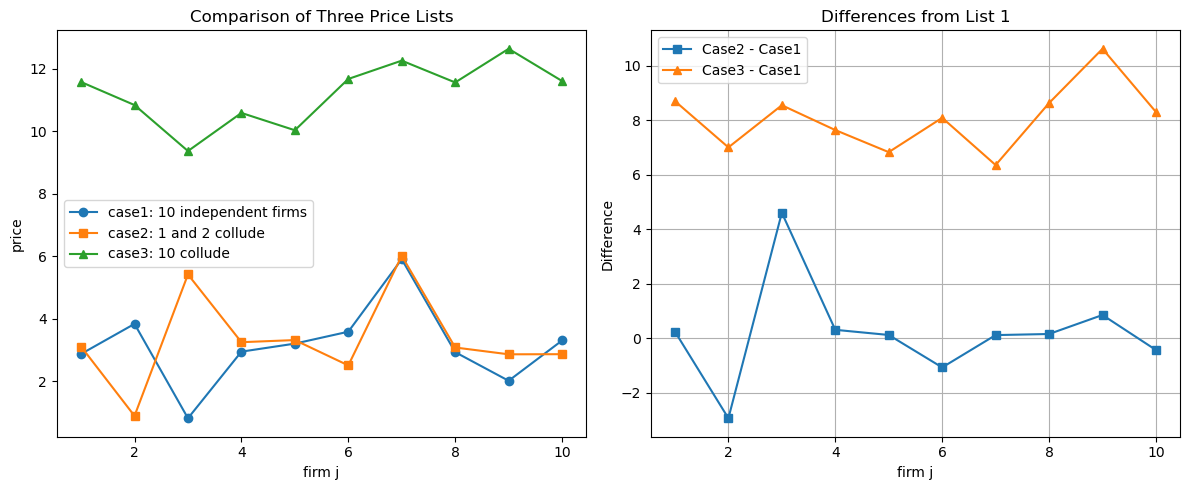

In [41]:
paint(price_full_competition, price_merge12, price_merge_full)

In [42]:
profit_total_1 = np.sum(calc_profit_nest(price_full_competition))
profit_total_1

profit_total_3= np.sum(calc_profit_nest(price_merge_full))
profit_total_3/profit_total_1
# after collusion, total profit increases by 3 times

3.0889157988668265